In [1]:
import numpy as np

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

**Answer to Question 1:**

In [4]:
from scipy import optimize
from scipy import interpolate

In [5]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def disutility(gamma, l):
    return gamma*l

def v2(c2, l2, rho, gamma):
    if l2 == 0: 
        c = b
    elif l2 == 1:
        c = w * h2 
    return utility(c2,rho) - disutility(gamma, l2)

def v1(c1, l1, rho, gamma, beta, w, h1, Delta, v2_interp):
    
    # a. v2 value, if l = 0
    h2_low = h1
    c2_low = b
    v2_low = v2_interp([h2_low, c2_low])[0]
    
    # b. v2 value, if l
    h2_high = h1 + l1 + Delta
    c2_high = w * h2
    v2_high = v2_interp([h2_high, c2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,rho) + beta*v2

In [6]:
def solve_period_2(rho, l2, gamma, Delta):

    # a. grids
    h2_vec = np.linspace(0.1, 1.5, 100) 
    v2_vec = np.empty(100)
    c2_vec = np.empty(100)

    # b. solve for each m2 in grid
    for i, h2 in enumerate(h2_vec):

        # i. objective
        obj = lambda c2: -v2(c2, l2, rho, gamma)

        # ii. initial value (consume half)
        x0 = h2/2

        # iii. optimizer
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,h2])

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return h2_vec,v2_vec,c2_vec

In [7]:
def solve_period_1(rho, gamma, beta, w, Delta, v1, v2_interp):

    # a. grids
    h1_vec = np.linspace(0.1,1.5,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,h1 in enumerate(h1_vec):
        
        # i. objective
        obj = lambda c1: -v1(c1, l1, rho, gamma, beta, w, h1, Delta, v2_interp)
        
        # ii. initial guess (consume half)
        x0 = h1/2
        
        # iii. optimize
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,h1])
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x
     
    return h1_vec,v1_vec,c1_vec

In [8]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1
l2 = 0
l1 = 1

def solve(rho, gamma, w, beta, Delta, v1):
    
    # a. solve period 2
    h2_vec,v2_vec,c2_vec = solve_period_2(rho, l2, gamma, Delta)
    
    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator((h2_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)
    
    # b. solve period 1
    h1_vec,v1_vec,c1_vec = solve_period_1(rho, gamma, beta, w, Delta, v1, v2_interp)
    
    return h1_vec,c1_vec

h1_vec,c1_vec = solve(rho, gamma, w, beta, Delta,v1)

NameError: name 'h2' is not defined

**new answer to question 1**

anaconda

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

def consumption(w,h,l):
    #outcome if consumer chooses to work else, outcome if he chooses not to work
    if l == 1:
        return w*h*l
    else:
        return b

def disutility(gamma, l):
    return gamma*l

def utility(w,h,l):
    return (consumption(w,h,l)**(1-rho))/(1-rho) - disutility(gamma, l)

In period 2, the human capital can take the below values:

In [13]:
#if consumer choses to work
h2_vec1 = h_vec + 1 + Delta*0.5

#if he chooses not to work
h2_vec0 = h_vec + 0 + Delta*0.5

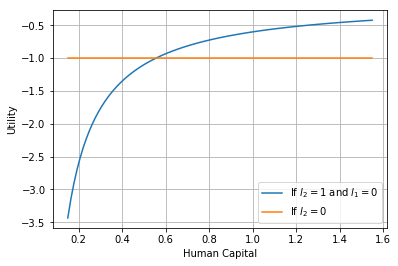

In [14]:
#Making a list which only contains the utility if she does not work in period 2. We only do this to be able to plot it.
#We plot the 
empty = np.empty(100)
utility_l0 = []
for i in empty:
    utility_l0.append(utility(w,h2_vec0,0))
    
plt.plot(h2_vec0, utility(w,h2_vec0,1), label = 'If $l_2=1$ and $l_1=0$')
#plt.plot(h2_vec0, utility(w,h2_vec1,1), label = 'If $l_2=1$ and $l_1=1$')
plt.plot(h2_vec0, utility_l0          , label = 'If $l_2=0$')
plt.ylabel('Utility'), plt.xlabel('Human Capital')
plt.legend()
plt.grid()
plt.show()

This graph tells us that if the human capital is lower than aprox 0,55, and the consumer chooses not to work in period 1, he is better off not working in period 2. However, if the human capital is greather, he is better off working in period 2. Also, we can see the the consumer is always better off working in both periods than any other combination.


Solving the problem in period 2- We can start with this and not include the code above

In [15]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def c(w,h,l,b):
    return w*h*l + b*(1-l)

def disutility(l,gamma):
    return gamma*l

def v2(w,h2,l2,b,rho,gamma):
    return utility(c(w,h2,l2,b),rho) - disutility(l2,gamma)

def v1(h1,l1,v2_interp,Delta,w,b,rho,gamma,beta):
    
    # from period 1 to period 2 the consumer can acummulate human capital based on the two functions below:
    # If humancapital is not accumulated, utility in period 2 becomes
    N_h2 = h1 + l1 + 0
    N_v2 = v2_interp([N_h2])[0]
    
    # b. If capital is accumulated, utility in period 2 becomes
    Y_h2 = h1 + l1 + Delta
    Y_v2 = v2_interp([Y_h2])[0]
    
    # c. Given the probabilities for ho
    v2 = 0.5*N_v2 + 0.5*Y_v2
    
    # d. total value
    return utility(c(w,h1,l1,b),rho) - disutility(l1,gamma) + beta*v2

In [16]:
def period_2(rho,gamma,Delta):
    
    # Vectors
    l2_vec = np.empty(100)
    v2_vec = np.empty(100)
    
    # Solve for each h2
    for i,h2 in enumerate(h_vec):
        
        # The individual decides whether to work or not by comparing his utility. If he is better off not working, we will have
        # l2=0 otherwise l2=1
        if v2(w,h2,1,b,rho,gamma) < v2(w,h2,0,b,rho,gamma):
            l2_vec[i] = 0
        else:
            l2_vec[i] = 1
        
        v2_vec[i] = v2(w,h2,l2_vec[i],b,rho,gamma)
        
    return l2_vec, v2_vec


NameError: name 'font' is not defined

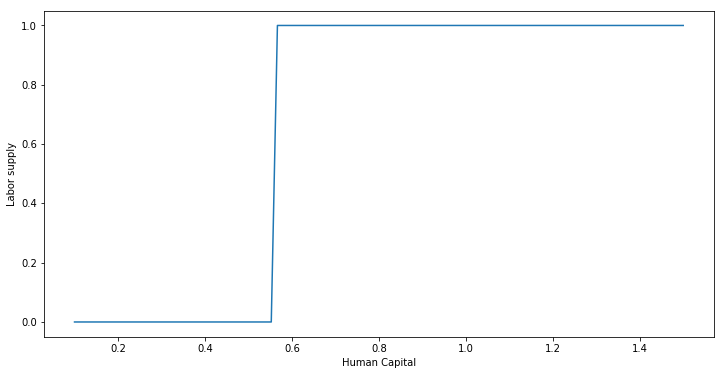

In [17]:

# Solving
l2_vec,v2_vec = period_2(rho,gamma,Delta)

# Figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec,l2_vec)

# Labels
ax.set_xlabel('Human Capital')
ax.set_ylabel('Labor supply')
ax.set_title('Labor Supply and Human Capital- period 2', fontdict=font)
ax.grid()


From the above figure, we can see that the individual will choose not to work in period 2 whenever the human capital (h_vec) is below 0.55 (aprox). If his human capital is above this level, he will get more utility by working in period 2.

**Answer to question 2**

In [18]:

def solve_period_1(rho,gamma,beta,Delta,v1,v2_interp):
    
    # Vectors
    l1_vec = np.empty(100)
    v1_vec = np.empty(100)
    
    # Solve for each h1
    for i,h1 in enumerate(h_vec):
             
        # The individual decides whether to work or not by comparing his utility. If he is better off not working, we will have
        # l1=0 otherwise l1=1
        if v1(h1,1,v2_interp,Delta,w,b,rho,gamma,beta) < v1(h1,0,v2_interp,Delta,w,b,rho,gamma,beta):
            l1_vec[i] = 0
        else:
            l1_vec[i] = 1
        
        v1_vec[i] = v1(h1,l1_vec[i],v2_interp,Delta,w,b,rho,gamma,beta)
        
    return l1_vec, v1_vec

# Construct interpolator
v2_interp = interpolate.RegularGridInterpolator((h_vec,), v2_vec, bounds_error=False, fill_value=None)

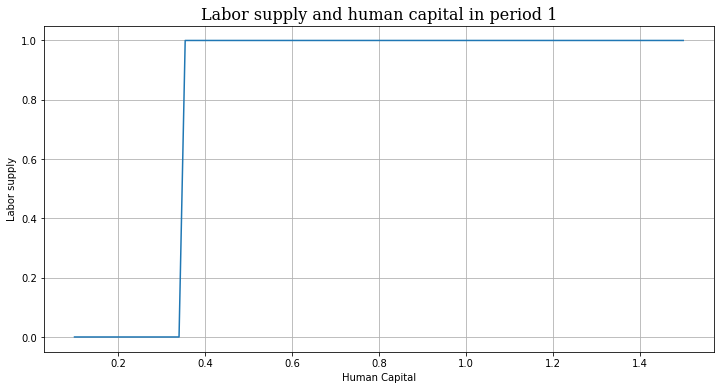

In [19]:
# Solving
l1_vec,v1_vec = solve_period_1(rho,gamma,beta,Delta,v1,v2_interp)

# Figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec,l1_vec)

# Labels
font = {'family':'serif','color':'black','weight':'normal','size': 16,}
ax.set_xlabel('Human Capital')
ax.set_ylabel('Labor supply')
ax.set_title('Labor supply and human capital in period 1', fontdict=font)
ax.grid()

Next- question 3. I will put the above cod in nice order, trying to combine the two types of graphs and then answer question 3

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [10]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Answer to question 1:**

In [1]:
#Importing all the necessary packages and activating pretty printing

import numpy as np
import sympy as sm
import matplotlib.pyplot as plt

sm.init_printing(use_unicode=True)

In [2]:
#Defining all the needed variables for the symbolic solution

v = sm.symbols('v_t')
y_t = sm.symbols('y_t')  
pi_t = sm.symbols('pi_t') 
h = sm.symbols('h')
alpha = sm.symbols('alpha')
b = sm.symbols('b')

pi_t_1 = sm.symbols('\pi_{t-1}')
y_t_1 = sm.symbols('y_{t-1}')
s_t = sm.symbols('s_t')
s_t_1 = sm.symbols('s_{t-1}')
gamma = sm.symbols('gamma')
phi = sm.symbols('\phi')

 
h, alpha, v, b, y_t, pi_t, pi_t_1, gamma, phi, y_t_1, s_t, s_t_1

In [3]:
AD = sm.Eq(pi_t, (1/(h*alpha))*(v - (1+b*alpha)*y_t))
SRAS = sm.Eq(pi_t, (pi_t_1 + gamma*y_t - phi*gamma*y_t_1 + s_t - phi*s_t_1))
AD, SRAS

**Solving for the equilibrium value of output ($y_{t}$) in three steps:**

1. **Step 1:** Solve AD wrt $\pi_{t}$
2. **Step 2:** Substistute in SRAS equation 
3. **Step 3:** Solve wrt $y_{t}$

In [4]:
AD_1 = sm.solve(AD, pi_t)
AD_1

In [5]:
AD_2 = SRAS.subs(pi_t, AD_1[0])
AD_2

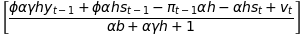

In [6]:
Output = sm.solve(AD_2, y_t)
Output

**Solving for the equilibrium value of inflation ($\pi_{t}$)**

**Note:** This will be done by substituting $y_{t}$ (as calculated above) into the SRAS equation and then solving it wrt $\pi_{t}$

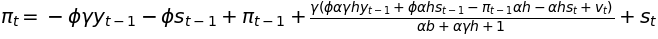

In [7]:
AS_1 = SRAS.subs(y_t, Output[0])
AS_1

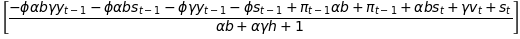

In [8]:
Inflation = sm.solve(AS_1, pi_t)
Inflation

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Answer to Question 2:**

In [11]:
# The two calculated equations are lambdified to be used
sol_output = sm.lambdify((y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b), Output[0])
sol_inflation = sm.lambdify((y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b), Inflation[0])

# Set the parameters equal to their values
def _sol_output(y_t_1, s_t_1, pi_t_1, s_t, v, phi=par['phi'], alpha=par['alpha'], gamma=par['gamma'], h=par['h'], b=par['b']):
    return sol_output(y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b)


def _sol_inflation(y_t_1, s_t_1, pi_t_1, s_t, v, phi=par['phi'], alpha=par['alpha'], gamma=par['gamma'], h=par['h'], b=par['b']):
    return sol_inflation(y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b)
                         

# The variables' values are inserted into the functions 
A = _sol_output(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0)
B = _sol_output(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0.1)

C = _sol_inflation(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0)
D = _sol_inflation(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0.1)
      
print('The values of y_t and pi_t when all the variables are equal to zero:')
print(f'y_t = {A}')
print(f'pi_t = {C}')
print('The values of y_t and pi_t when all the variables are equal to zero, except v = 0.1')
print(f'y_t = {B}')
print(f'pi_t = {D}')

The values of y_t and pi_t when all the variables are equal to zero:
y_t = 0.0
pi_t = 0.0
The values of y_t and pi_t when all the variables are equal to zero, except v = 0.1
y_t = 0.0244140625
pi_t = 0.0018310546875


**Conclusion:** from the above calculated values, we can conclude that when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$, the equlibrium is $(\pi_t,y_t) = (0,0)$. On the other hand when the economy suffers from a positive demand shock ($v_t = 0.1$ and the rest of the parameters are equal to zero), the equilibrium is $(\pi_t,y_t) = (0.0244140625,0.0018310546875)$.

**Note:** To plot the AD-SRAS we need the equations to express the relationship between $\pi_t$ and $y_t$; the lambdified equations don't express directly that relationship, so we will define the original AD and SRAS functions and then plot them. 

In [12]:
# Defining the AD and SRAS functions to plot them
def AD(h, alpha, v, b, y_t):
    return (1/(h*alpha))*(v - (1+b*alpha)*y_t)
    
def SRAS(pi_t_1, gamma, y_t, phi, y_t_1, s_t, s_t_1):
    return (pi_t_1 + gamma*y_t - phi*gamma*y_t_1 + s_t - phi*s_t_1)

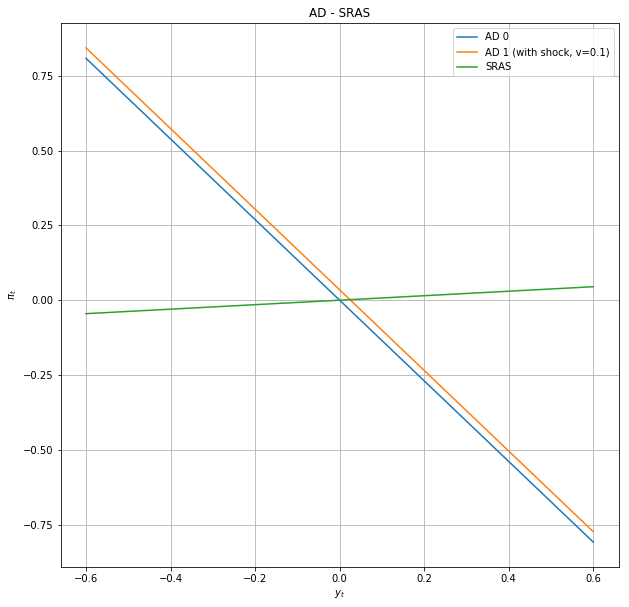

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

y_lin = np.linspace(-0.6, 0.6, 100)
AD_0 = AD(h=par['h'], alpha=par['alpha'], v=0, b=par['b'], y_t=y_lin)
AD_1 = AD(h=par['h'], alpha=par['alpha'], v=0.1, b=par['b'],y_t=y_lin)
SRAS_total = SRAS(pi_t_1=0, gamma=par['gamma'], y_t=y_lin, phi=par['phi'], y_t_1=0, s_t=0, s_t_1=0) 

plt.plot(y_lin, AD_0, label='AD 0')
plt.plot(y_lin, AD_1, label='AD 1 (with shock, v=0.1)')
plt.plot(y_lin, SRAS_total, label='SRAS')
plt.grid(True)

plt.title('AD - SRAS')
plt.xlabel('$y_t$')
plt.ylabel('$\pi_t$')
plt.legend(loc='upper right')
plt.show()

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [14]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Answer to Question 3:**

First we will define the functions of the two shocks, which will be used to fill the vectors of $v_{t}$ and $s_{t}$

**!!!Note:** don't forget to run the above cell with the parameter values

In [15]:
def v_t(v_t_1, x_t, delta=par['delta']):
    return delta*v_t_1 + x_t

def s_t(s_t_1, c_t, omega=par['omega']):
    return omega*s_t_1 + c_t

In [22]:
# Define three periods to check which one will be better
T1 = 25
#T2 = 50
#T3 = 100

# Creating the vectors that will be needed for the simulation
y_vec = [0]
pi_vec = [0]
v_vec = [0]
x_vec = np.zeros(T1) #all the demand shocks to be equal to 0
x_vec[0] = 0.1 #only the shock in the first period should not be equal to 0 
s_vec = [0]
c_vec = np.zeros(T1) #all the supply shocks are 0 

#x_vec

In [23]:
for t in range (1,T1):
    
    v_vec.append(v_t(v_vec[t-1],x_vec[t]))
    s_vec.append(s_t(s_vec[t-1],c_vec[t]))
    y_vec.append(AD(h=par['h'], alpha=par['alpha'], v=v_vec[t], b=par['b'], y_t=y_vec[t]))
    pi_vec.append(SRAS(pi_t_1=pi_vec[t-1], gamma=par['gamma'], y_t=y_vec[t], phi=par['phi'], y_t_1=y_vec[t-1], s_t=s_vec[t], s_t_1=s_vec[t-1]))

IndexError: list index out of range

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [ ]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [ ]:
import numpy as np
import scipy as sp
from scipy import interpolate
import sympy as sm
from IPython.display import display
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
sm.init_printing(use_unicode=True)



In [ ]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Since budget share is given by Demand/Income:
$$
\begin{eqnarray*}
\frac{x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})}{I^j}&=&\frac{\beta^{j}_i\frac{I^j}{p_{i}}}{I^j}&=&\frac{\beta^{j}_i}{p_{i}}  \\
\end{eqnarray*}
$$
we can get the histogram of budget shares by ploting betas.


Text(0.5, 1.0, 'the budget shares of three goods')

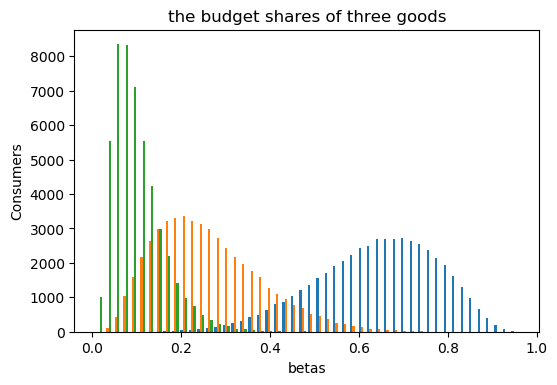

In [63]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)

ax.hist(betas,bins=50)

ax.set_xlabel('betas')
ax.set_ylabel('Consumers')

ax.set_title('the budget shares of three goods')

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

In [ ]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import itertools
import time
from matplotlib.ticker import FuncFormatter


In [ ]:
#demand function
def demand_good_1_fun(betas,p1,p2,e1,e2,e3):
    I = p1*e1+p2*e2+e3
    return betas[:,0]*I/p1

def demand_good_2_fun(betas,p1,p2,e1,e2,e3):
    I = p1*e1+p2*e2+e3
    return betas[:,1]*I/p2

def demand_good_3_fun(betas,p1,p2,e1,e2,e3):
    I = p1*e1+p2*e2+e3
    return betas[:,2]*I
    

In [ ]:
def excess_demand_good_1_func(betas,p1,p2,e1,e2,e3):
    
    # a. demand
    demand = np.sum(demand_good_1_fun(betas,p1,p2,e1,e2,e3))
    
    # b. supply
    supply = np.sum(e1)
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

def excess_demand_good_2_func(betas,p1,p2,e1,e2,e3):
    
    # a. demand
    demand = np.sum(demand_good_2_fun(betas,p1,p2,e1,e2,e3))
    
    # b. supply
    supply = np.sum(e2)
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

def excess_demand_good_3_func(betas,p1,p2,e1,e2,e3):
    
    # a. demand
    demand = np.sum(demand_good_2_fun(betas,p1,p2,e1,e2,e3))
    
    # b. supply
    supply = np.sum(e3)
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

In [ ]:
p1_s = np.linspace(1,10,100)
p2_s = np.linspace(1,10,100)

In [ ]:
# Initiating empty grids for excess demands
excess_1_grid = np.empty((100,100))
excess_2_grid = np.empty((100,100))

# Calculating excess-demands for each price-combination
for i,p1 in enumerate(p1_s):
    for j,p2 in enumerate(p2_s):
        excess_1_grid[i,j] = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
        excess_2_grid[i,j] = excess_demand_good_2_func(betas,p1,p2,e1,e2,e3)
        
p1_grid, p2_grid = np.meshgrid(p1_s, p2_s) 

In [ ]:
fig = plt.figure(figsize=(10,10))

ex1 = fig.add_subplot(2,1,1, projection='3d')
fig1 = ex1.plot_surface(p1_grid,p2_grid,excess_1_grid)
ex1.invert_xaxis()

ex1.set_xlabel('$p_1$')
ex1.set_ylabel('$p_2$')
ex1.set_zlabel('Excess demand')
ex1.set_title('Good 1')

ex2 = fig.add_subplot(2,1,2, projection='3d')
fig2=ex2.plot_surface(p1_grid,p2_grid,excess_2_grid)
ex2.invert_xaxis()

ex2.set_xlabel('$p_1$')
ex2.set_ylabel('$p_2$')
ex2.set_zlabel('Excess demand')
ex2.set_title('Good 2')

plt.show()

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [ ]:
def find_equilibrium(betas,p1,p2,e1,e2,e3,kappa=0.1,eps=1e-8,maxiter=500):
    
    t = 0
    while True:

        # a. step 1: excess demand
        Z1 = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
        Z2 = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
        
        # b: step 2: stop?
        if  np.abs(Z1) < eps and np.abs(Z2) < eps:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            break    
    
        # c. step 3: update p1
        p1 = p1 + kappa*Z1/N
        p2 = p2 + kappa*Z2/N
            
        # d. step 4: return 
        if t < 5 or t%25 == 0:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
        elif t == 5:
            print('   ...')
            
        t += 1    

    return p1,p2

In [ ]:
p1 = 1.4
p2 = 1
kappa = 0.1
eps = 1e-8

p1 = find_equilibrium(betas,p1,p2,e1,e2,e3=2.054,kappa=kappa,eps=eps)

In [ ]:
#Ensure that excess demand of both goods are (almost) zero
Z1 = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
Z2 = excess_demand_good_2_func(betas,p1,p2,e1,e2,e3)
print(Z1,Z2)
assert(np.abs(Z1) < eps)
assert(np.abs(Z2) < eps)

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

In [ ]:
def utility(betas,p1, p2, e1, e2, e3, gamma):
    
    I = p1*e1+p2*e2+e3
    x1 = betas[:,0]*(I/p1)
    x2 = betas[:,1]*(I/p2)
    x3 = betas[:,2]*I
    
    return (x1**betas[:,0]+x2**betas[:,1]+x3**betas[:,2])**gamma

In [ ]:
# Calling function to find vector of utilities
u_vec = utility(betas,p1, p2, e1, e2, e3, gamma)

plt.hist(u_vec,100)

plt.xlabel('Utility')
plt.ylabel('Consumers')
plt.title('Utilities Distribution')


In [ ]:
mean = np.mean(u_vec)
variance = np.var(u_vec)

mean,variance

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?